<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA_public/blob/master/Session6/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Model
from keras.layers.merge import concatenate

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


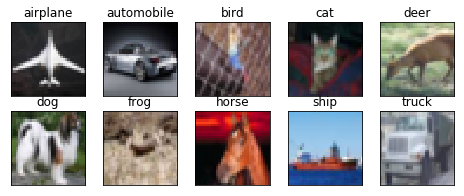

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Define the model

input = Input(shape=(32, 32, 3,))


# Block 1 (normal conv.) #

Block1_conv1 = Conv2D(50, (3,3), border_mode='same', name='Block1_conv1')(input)
Block1_relu1 = Activation('relu')(Block1_conv1)
Block1_bn1 = BatchNormalization(name='Block1_bn1')(Block1_relu1)
Block1_d1 = Dropout(0.25)(Block1_bn1)
Block1_conv2 = Conv2D(100, (3,3), border_mode='same', name='Block1_conv2')(Block1_d1)
Block1_relu2 = Activation('relu')(Block1_conv2)
Block1_bn2 = BatchNormalization(name='Block1_bn2')(Block1_relu2)
Block1_d2 = Dropout(0.25)(Block1_bn2)
Block1_conv3 = Conv2D(200, (3,3), border_mode='same', name='Block1_conv3')(Block1_d2)
Block1_relu3 = Activation('relu')(Block1_conv3)
Block1_bn3 = BatchNormalization(name='Block1_bn3')(Block1_relu3)

Block1 = MaxPooling2D(pool_size=(2, 2))(Block1_bn3)


# Block 2 (Spatially Separable Conv.) #

Block2_conv1 = Conv2D(50, (1,1), name='Block2_conv1')(Block1)
Block2_relu1 = Activation('relu')(Block2_conv1)
Block2_bn1 = BatchNormalization(name='Block2_bn1')(Block2_relu1)
Block2_d1 = Dropout(0.25)(Block2_bn1)
Block2_conv2_3x1 = Conv2D(50, (3,1), border_mode='same', name='Block2_conv2_3x1')(Block2_d1)
Block2_conv2_1x3 = Conv2D(100, (1,3), border_mode='same', name='Block2_conv2_1x3')(Block2_conv2_3x1)
Block2_relu2 = Activation('relu')(Block2_conv2_1x3)
Block2_bn2 = BatchNormalization(name='Block2_bn2')(Block2_relu2)
Block2_d2 = Dropout(0.25)(Block2_bn2)
Block2_conv3_3x1 = Conv2D(100, (3,1), border_mode='same', name='Block2_conv3_3x1')(Block2_d2)
Block2_conv3_1x3 = Conv2D(200, (1,3), border_mode='same', name='Block2_conv3_1x3')(Block2_conv3_3x1)
Block2_relu3 = Activation('relu')(Block2_conv3_1x3)
Block2_bn3 = BatchNormalization(name='Block2_bn3')(Block2_relu3)

Block2 = MaxPooling2D(pool_size=(2, 2))(Block2_bn3)


# Block 3 (Depthwise Separable Conv.) #

Block3_conv1 = Conv2D(50, (1,1), name='Block3_conv1')(Block2)
Block3_relu1 = Activation('relu')(Block3_conv1)
Block3_bn1 = BatchNormalization(name='Block3_bn1')(Block3_relu1)
Block3_d1 = Dropout(0.25)(Block3_bn1)
Block3_conv2 = SeparableConv2D(100, (3,3), border_mode='same', name='Block3_conv2')(Block3_d1)
Block3_relu2 = Activation('relu')(Block3_conv2)
Block3_bn2 = BatchNormalization(name='Block3_bn2')(Block3_relu2)
Block3_d2 = Dropout(0.25)(Block3_bn2)
Block3_conv3 = SeparableConv2D(200, (3,3), border_mode='same', name='Block3_conv3')(Block3_d2)
Block3_relu3 = Activation('relu')(Block3_conv3)
Block3_bn3 = BatchNormalization(name='Block3_bn3')(Block3_relu3)

Block3 = MaxPooling2D(pool_size=(2, 2))(Block3_bn3)


# Block 4 (Grouped Convolution using 3x3, 5x5) #

Block4_conv1 = Conv2D(50, (1,1), name='Block4_conv1')(Block3)
Block4_relu1 = Activation('relu')(Block4_conv1)
Block4_bn1 = BatchNormalization(name='Block4_bn1')(Block4_relu1)
Block4_d1 = Dropout(0.25)(Block4_bn1)
Block4_conv2 = Conv2D(100, (3,3), border_mode='same', name='Block4_conv2')(Block4_d1)
Block4_relu2 = Activation('relu')(Block4_conv2)
Block4_bn2 = BatchNormalization(name='Block4_bn2')(Block4_relu2)

Block4_conv3 = Conv2D(100, (5,5), border_mode='same', name='Block4_conv3')(Block4_d1)
Block4_relu3 = Activation('relu')(Block4_conv3)
Block4_bn3 = BatchNormalization(name='Block4_bn3')(Block4_relu3)

x1 = concatenate([Block4_bn2, Block4_bn3])


# Block 5 (Grouped Convolution using 3x3 only, dilation = 1 and 2) #
x2 = Dropout(0.25)(x1)
Block5_conv1 = Conv2D(100, (3,3), border_mode='same',dilation_rate=(1, 1), name='Block5_conv1')(x2)
Block5_relu1 = Activation('relu')(Block5_conv1)
Block5_bn1 = BatchNormalization(name='Block5_bn1')(Block5_relu1)

Block5_conv2 = Conv2D(100, (5,5), border_mode='same', name='Block5_conv2')(x2)
Block5_relu2 = Activation('relu')(Block5_conv2)
Block5_bn2 = BatchNormalization(name='Block5_bn2')(Block5_relu2)

x3 = concatenate([Block5_bn1, Block5_bn2])


# Final block #

Block6_conv1 = Conv2D(20, (1,1), name='Block6_conv1')(x3)
Block6_relu1 = Activation('relu')(Block6_conv1)
Block6_bn1 = BatchNormalization(name='Block6_bn1')(Block6_relu1)
Block6_conv2 = Conv2D(num_classes, (4,4) , name='Block6_conv2')(Block6_bn1)
Block6_Flat = Flatten()(Block6_conv2)
output = Activation('softmax')(Block6_Flat)

my_model = Model(inputs=[input], outputs=[output])
# model.summary()

# Compile the model
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0619 11:56:25.056628 139967792809856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 11:56:25.095160 139967792809856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (3, 3), name="Block1_conv1", padding="same")`
  import sys
W0619 11:56:25.107559 139967792809856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 11:56:25.147932 139967792809856 deprecation_wrapper.py:119] From /usr/local/lib/pyth

In [0]:
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Block1_conv1 (Conv2D)           (None, 32, 32, 50)   1400        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 50)   0           Block1_conv1[0][0]               
__________________________________________________________________________________________________
Block1_bn1 (BatchNormalization) (None, 32, 32, 50)   200         activation_1[0][0]               
__________________________________________________________________________________________________
dropout_1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  from ipykernel import kernelapp as app
W0619 11:56:30.272007 139967792809856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (f

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0075.
390/390 [==============================] - 48s 122ms/step - loss: 1.6257 - acc: 0.4090 - val_loss: 2.3018 - val_acc: 0.3897
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0056861259.
390/390 [==============================] - 42s 107ms/step - loss: 1.1581 - acc: 0.5828 - val_loss: 2.3187 - val_acc: 0.4390
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0045787546.
390/390 [==============================] - 40s 103ms/step - loss: 0.9672 - acc: 0.6534 - val_loss: 1.3725 - val_acc: 0.5844
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0038323965.
390/390 [==============================] - 40s 103ms/step - loss: 0.8424 - acc: 0.7009 - val_loss: 0.8172 - val_acc: 0.7165
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0032952548.
390/390 [==============================] - 40s 104ms/step - loss: 0.7515 - acc: 

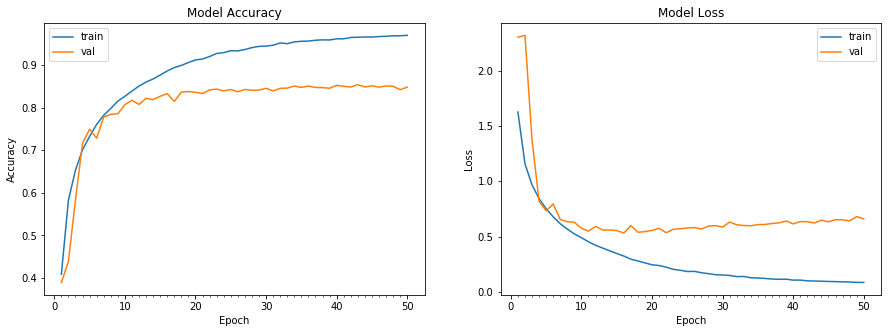

Accuracy on test data is: 84.81


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.0075 * 1/(1 + 0.319 * epoch), 10)

# train the model
start = time.time()
# Train the model
my_model_info = my_model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(my_model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, my_model))